Column descriptions: 
- a1 - f7: ID of wind turbine
- connect: Number of wind turbines connected
- wsn: Wind Speed
- ym: Yaw Angle
- pow: Active Power

In [93]:
import xarray as xr
import pandas as pd

In [94]:
# Open the .nc file
ds = xr.open_dataset("C:/Users/leopu/OneDrive/Programming/Python/danish-turbine-prediction/norre_m2_all.nc")

# Convert the Dataset into a DataFrame
df = ds.to_dataframe()

In [95]:
ds

<xarray.Dataset>
Dimensions:     (time: 72577)
Coordinates:
  * time        (time) datetime64[ns] 1991-12-22T23:36:00 ... 1993-06-27T23:1...
Data variables: (12/260)
    connect     (time) float64 42.0 42.0 42.0 42.0 42.0 ... 19.0 12.0 8.0 5.0
    connect_qc  (time) int16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    d31_1       (time) float64 257.4 259.6 260.1 255.6 253.0 ... nan nan nan nan
    d31_1_qc    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    d34_2       (time) float64 253.6 255.8 257.1 254.1 252.2 ... nan nan nan nan
    d34_2_qc    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    ...          ...
    f7_pow      (time) float64 113.5 98.9 78.6 113.8 128.9 ... nan nan nan nan
    f7_pow_qc   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    f7_wsn      (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    f7_wsn_qc   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    f7_ym       (time) float64 -9.38 -9.68 -5.21 -8.5 -5.75 ... nan nan nan nan
    f7_ym_qc    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes: (12/26)
    title:                   Wind farm data from Norrekaer Enge, DK
    authors:                 Kurt Schaldemose Hansen, Nikola Vasiljević and S...
    summary:                 This dataset includes SCADA data and mast measur...
    comment:                 
    history:                 2022-01-27T10:49:35\tUpdated metadata informatio...
    institution:             DTU Wind Energy
    ...                      ...
    featureType:             trajectoryProfile
    cdm_data_type:           Trajectory
    date_create:             2022-01-27T10:49:35
    date_update:             2022-01-27T10:49:35
    data_mode:               Mixed
    source:                  physical

In [96]:
cols_to_keep = [c for c in df.columns if "a2" in c]

In [97]:
a2_df = df[cols_to_keep]

cols_to_drop = [c for c in a2_df.columns if "qc" in c]
a2_df = a2_df.drop(cols_to_drop, axis=1)
a2_df = a2_df.fillna(0)

In [98]:
#a2_df["a2_wsn_kmh"] = [wsn*3.6 for wsn in a2_df["a2_wsn"].tolist()]

In [99]:
a2_df.head(10)

,a2_pow,a2_wsn,a2_ym
time,,,
1991-12-22 23:36:00,159.5,0.0,0.0
1991-12-22 23:46:00,157.0,0.0,0.0
1991-12-22 23:56:00,124.4,0.0,0.0
1991-12-23 00:06:00,138.5,0.0,0.0
1991-12-23 00:16:00,148.6,0.0,0.0
1991-12-23 00:26:00,156.2,0.0,0.0
1991-12-23 00:36:00,165.0,0.0,0.0
1991-12-23 00:46:00,164.6,0.0,0.0
1991-12-23 00:56:00,144.5,0.0,0.0


<Axes: xlabel='time'>

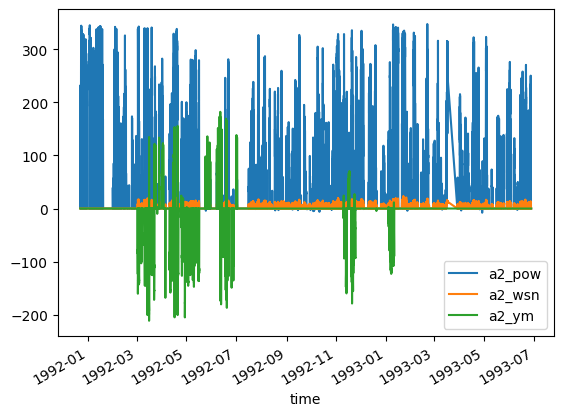

In [101]:
a2_df.plot()

In [102]:
a2_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72577 entries, 1991-12-22 23:36:00 to 1993-06-27 23:13:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a2_pow  72577 non-null  float64
 1   a2_wsn  72577 non-null  float64
 2   a2_ym   72577 non-null  float64
dtypes: float64(3)
memory usage: 2.2 MB


In [103]:
a2_df["target"] = a2_df["a2_pow"].shift(-6)
a2_df = a2_df.fillna(0)

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error, r2_score

from lightgbm import LGBMRegressor

In [105]:
X = a2_df.drop(["target", "a2_pow"], axis=1)
y = a2_df["target"].tolist()

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [107]:
X_train

,a2_wsn,a2_ym
time,,
1992-09-15 09:06:00,6.33,0.0
1993-01-06 03:53:00,0.00,0.0
1992-04-23 15:32:00,0.00,0.0
1992-10-15 10:35:00,0.00,0.0
1992-09-13 08:59:00,7.78,0.0
...,...,...
1992-10-04 02:46:00,0.00,0.0
1992-02-16 16:32:00,0.00,0.0
1993-02-10 07:16:00,0.00,0.0


In [108]:
model = LGBMRegressor().fit(X_train, y_train)

y_hat = model.predict(X_test)

r2, mse = r2_score(y_test, y_hat), mean_squared_error(y_test, y_hat)
print(r2, mse)

0.46823498718538126 2754.2096430450442


In [109]:
model.feature_importances_

array([1476, 1524])

In [124]:
# trying out statsforecast
a2_df_forecast = a2_df.reset_index().rename(columns={"time": "ds", "target": "y"}).reset_index(drop=True)
a2_df_forecast["unique_id"] = ["a2"]*len(a2_df_forecast["a2_pow"])
a2_df_forecast = a2_df_forecast.drop(["a2_pow", "a2_wsn", "a2_ym"], axis=1)


In [131]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

sf = StatsForecast(
    models=[AutoARIMA(season_length = 12)],
    freq="T",
)

sf.fit(a2_df_forecast)


TypeError: ord() expected string of length 1, but int found

In [ ]:
# Save the DataFrame as a .parquet file
df.to_parquet('output.parquet')

In [25]:
df.index.min()

Timestamp('1991-12-22 23:36:00')